In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Tue Aug 29 00:30:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   26C    P8    16W / 230W |    804MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [3]:
n_mels = 1024
n_outputs = 61
n_frames = 400

### Model

In [4]:
from model.model_ecapa_transformer_reg import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, h_dim=512, out_dim=n_outputs)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('done')

done


### Load

In [5]:
save_dir = '/data/scpark/save/lips/train08.28-2/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if True:
    step, model, _, optimizer = load(save_dir, 6787, model, None, optimizer)

total 1177720
-rw-rw-r-- 1 scpark scpark 602982156  8월 29 00:30 save_6787
-rw-rw-r-- 1 scpark scpark      6628  8월 29 00:27 events.out.tfevents.1693214206.GPUSVR01
-rw-rw-r-- 1 scpark scpark 602982156  8월 28 18:18 save_0
loaded /data/scpark/save/lips/train08.28-2/save_6787


In [6]:
# # warm start
# checkpoint = torch.load('/data/scpark/save/vspeech/train08.14-1/save_80000', map_location=torch.device('cpu'))
# model_state_dict = model.state_dict()

# for key in checkpoint['model_state_dict']:
#     if key in model_state_dict.keys():
#         if checkpoint['model_state_dict'][key].shape == model_state_dict[key].shape:
#             model_state_dict[key] = checkpoint['model_state_dict'][key]
#             print(key)
# model.load_state_dict(model_state_dict, strict=True)
# print('warm start')

### Dataset

In [7]:
import os
from data.arkit_dataset import LipsDataset, CombinedDataset, CombinedCollate

root_dir = '/data/speech/digital_human/preprocessed/'

def get_files(dir):
    data = []
    files = sorted([os.path.join(dir, file) for file in os.listdir(dir)])
    for file in files:
        if file.endswith('.npy') and 'ARKit' in file:
            data.append(file)
        if os.path.isdir(file):
            data.extend(get_files(os.path.join(dir, file)))
    return data

files = get_files(root_dir)
print(len(files))

train_datasets = []
test_datasets = []

def get_sid(file):
    names = ['No Speaker', 'jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
    for sid, name in enumerate(names):
        if name in file:
            return sid
    return 0

for file in files:
    sid = get_sid(file)
    print(sid, file)
    dataset = LipsDataset(file, n_mels, n_frames, sid=sid, mel=False)
    if '_10_' in file:
        test_datasets.append(dataset)
    else:
        train_datasets.append(dataset)
print(len(train_datasets), len(test_datasets))

76
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_10_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_11_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_12_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_2_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_3_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_4_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_5_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_8_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_9_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_10_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy
2

In [8]:
train_loader = torch.utils.data.DataLoader(CombinedDataset(train_datasets), 
                                           num_workers=16, shuffle=True, batch_size=32, collate_fn=CombinedCollate())
test_loader = torch.utils.data.DataLoader(CombinedDataset(test_datasets), 
                                          num_workers=10, shuffle=True, batch_size=10, collate_fn=CombinedCollate())
print('done')

done


In [9]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
wav2vec = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean").to(device)
print('done')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


done


In [10]:
from torchaudio.transforms import Resample
resample = Resample(24000, 16000).to(device)

def get_states(wav, size, layer=16):
    # 24k to 16k
    wav = resample(wav)
    # Get probs.
    with torch.no_grad():
        states = wav2vec(wav, output_hidden_states=True).hidden_states[layer].transpose(1, 2)
    # Resizing
    states = F.interpolate(states, size=size, mode='linear').detach()
    return states


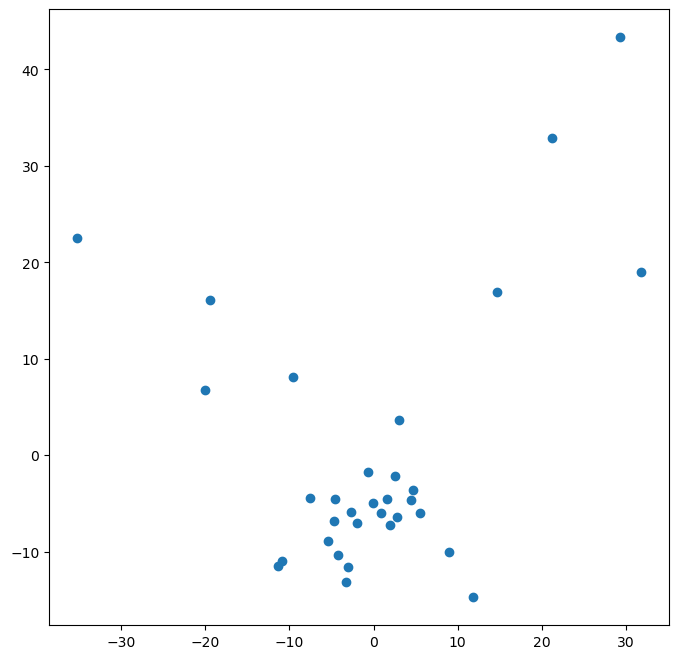

test : 0 0.02456166036427021
test : 1 0.02505398355424404
test : 2 0.025382135063409805
test : 3 0.02023017220199108
test : 4 0.02372903563082218
test : 5 0.023166870698332787
test : 6 0.023147989064455032
test : 7 0.02465108223259449
test : 8 0.023654421791434288
test : 9 0.0260822381824255
test_loss : 0.023965958505868912
6801
loss 0.0259962510317564
6801 0.0259962510317564
6802
loss 0.022515665739774704
6802 0.022515665739774704
6803
loss 0.02397616021335125
6803 0.02397616021335125
6804
loss 0.02800571359694004
6804 0.02800571359694004
6805
loss 0.026621751487255096
6805 0.026621751487255096
6806
loss 0.0237895380705595
6806 0.0237895380705595
6807
loss 0.023451443761587143
6807 0.023451443761587143
6808
loss 0.02551449090242386
6808 0.02551449090242386
6809
loss 0.026922833174467087
6809 0.026922833174467087
6810
loss 0.021256063133478165
6810 0.021256063133478165
6811
loss 0.022079847753047943
6811 0.022079847753047943
6812
loss 0.023963535204529762
6812 0.023963535204529762
6813

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
        inputs = get_states(torch.Tensor(batch['wav']).to(device), targets.shape[-1])
        sid = torch.Tensor(batch['sid']).int().to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets, sid)
        
        print(step)
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 100 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 100 == 0:
            display.clear_output()
            
            # (b, 2)
            speaker = outputs['speaker'].data.cpu().numpy()
            plt.figure(figsize=[8, 8])
            plt.scatter(speaker[:, 0], speaker[:, 1])
            plt.show()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
                inputs = get_states(torch.Tensor(batch['wav']).to(device), targets.shape[-1])
                sid = torch.Tensor(batch['sid']).int().to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets, sid)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
#             plt.figure(figsize=[18, 4])
#             librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
#             plt.show()

#             plt.figure(figsize=[18, 4])
#             librosa.display.specshow(outputs['y_pred'][0].data.cpu().numpy(), cmap='magma')
#             plt.show()
            
#             for i in [20, 37]:
#                 plt.figure(figsize=[18, 2])
#                 plt.title(str(i))
#                 plt.plot(targets[0].data.cpu().numpy()[i])
#                 plt.plot(outputs['y_pred'][0].data.cpu().numpy()[i])
#                 plt.show()

        if step % 10000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)

In [ ]:
# (b, 2)
speaker = outputs['speaker'].data.cpu().numpy()
plt.figure(figsize=[8, 8])
plt.scatter(speaker[:, 0], speaker[:, 1])
plt.show()


In [ ]:
print('done')